In [3]:
import requests
import pandas as pd
from time import sleep
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
# Import API key from config file
from config import TMDB_API_KEY

# Get API key: from environment variable or config file
api_key = os.getenv("TMDB_API_KEY") or TMDB_API_KEY

# TMDB base URL
base_url = "https://api.themoviedb.org/3"


In [5]:
def fetch_movie_data(movie_id):
    """Fetch movie details from TMDB API."""
    url = f"{base_url}/movie/{movie_id}"
    params = {
        "api_key": api_key,
        "language": "en-US"
    }
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching data for movie ID {movie_id}: {response.status_code}")
        try:
            print(response.json())  # Print error details from API
        except:
            pass
        return None

def main():
    """Main pipeline to fetch movies and build a DataFrame."""
    # Example movie IDs (test small batch first)
    movie_ids = [550, 551, 552, 553, 554]
    
    movie_data_list = []

    for movie_id in movie_ids:
        movie_data = fetch_movie_data(movie_id)
        if movie_data:
            print("\n🔍 API Response for Movie ID:", movie_id)
            print(json.dumps(movie_data, indent=4))  # Pretty print JSON for clarity
            
            movie_data_list.append(movie_data)
        sleep(1)  # Be respectful of rate limits

    # Convert to DataFrame
    if movie_data_list:
        df = pd.DataFrame(movie_data_list)

        print("\n Fetched Movie DataFrame:")
        print(df.head())

        print("\n DataFrame Columns:")
        print(df.columns)

        # Save DataFrame (optional)
        # df.to_csv("tmdb_movies_raw.csv", index=False)

    else:
        print("No movie data fetched.")

if __name__ == "__main__":
    main()



🔍 API Response for Movie ID: 550
{
    "adult": false,
    "backdrop_path": "/xRyINp9KfMLVjRiO5nCsoRDdvvF.jpg",
    "belongs_to_collection": null,
    "budget": 63000000,
    "genres": [
        {
            "id": 18,
            "name": "Drama"
        }
    ],
    "homepage": "http://www.foxmovies.com/movies/fight-club",
    "id": 550,
    "imdb_id": "tt0137523",
    "origin_country": [
        "US"
    ],
    "original_language": "en",
    "original_title": "Fight Club",
    "overview": "A ticking-time-bomb insomniac and a slippery soap salesman channel primal male aggression into a shocking new form of therapy. Their concept catches on, with underground \"fight clubs\" forming in every town, until an eccentric gets in the way and ignites an out-of-control spiral toward oblivion.",
    "popularity": 24.39,
    "poster_path": "/pB8BM7pdSp6B6Ih7QZ4DrQ3PmJK.jpg",
    "production_companies": [
        {
            "id": 711,
            "logo_path": "/tEiIH5QesdheJmDAqQwvtN60727.png"

In [6]:
url = f"https://api.themoviedb.org/3/discover/movie"
params = {
    "api_key": api_key,
    "language": "en-US",
    "primary_release_date.gte": "2000-01-01",
    "primary_release_date.lte": "2024-12-31",
    "page": 1
}

response = requests.get(url, params=params)
data = response.json()

print(f"Total movies matching query: {data['total_results']}")
print(f"Total pages: {data['total_pages']}")


Total movies matching query: 579310
Total pages: 28966


In [11]:
#  Storage for results
movie_data = []

# Loop through TMDB's /discover/movie endpoint
for page in range(1, 400):  # Start with 2 pages for quick testing; increase to 201 later
    discover_url = f"{base_url}/discover/movie"
    params = {
        "api_key": api_key,
        "language": "en-US",
        "sort_by": "popularity.desc",
        "include_adult": False,
        "include_video": False,
        "page": page,
        "primary_release_date.gte": "2000-01-01",
        "primary_release_date.lte": "2024-12-31"
    }

    response = requests.get(discover_url, params=params)
    if response.status_code != 200:
        print(f"Failed on page {page} — Status: {response.status_code}")
        print(response.json())  # Show error
        break

    movies = response.json().get("results", [])

    for movie in movies:
        movie_id = movie["id"]

        # Fetch movie details
        movie_details = requests.get(f"{base_url}/movie/{movie_id}", params={"api_key": api_key}).json()
        credits = requests.get(f"{base_url}/movie/{movie_id}/credits", params={"api_key": api_key}).json()

        # Get director and top actor
        director = next((c["name"] for c in credits.get("crew", []) if c["job"] == "Director"), None)
        cast = [c["name"] for c in credits.get("cast", [])][:1]

        # Collect relevant fields
        movie_data.append({
            "title": movie_details.get("title"),
            "release_date": movie_details.get("release_date"),
            "budget": movie_details.get("budget"),
            "revenue": movie_details.get("revenue"),
            "runtime": movie_details.get("runtime"),
            "genres": [g["name"] for g in movie_details.get("genres", [])],
            "popularity": movie_details.get("popularity"),
            "vote_average": movie_details.get("vote_average"),
            "vote_count": movie_details.get("vote_count"),
            "original_language": movie_details.get("original_language"),
            "production_companies": [pc["name"] for pc in movie_details.get("production_companies", [])],
            "belongs_to_collection": movie_details.get("belongs_to_collection") is not None,
            "director": director,
            "lead_actor": cast[0] if cast else None
        })

    print(f"Page {page} complete — movies collected: {len(movie_data)}")
    sleep(0.3)

# Convert to DataFrame
df_movies = pd.DataFrame(movie_data)

# Print the DataFrame
df_movies.head() # Preview first few rows


Page 1 complete — movies collected: 20
Page 2 complete — movies collected: 40
Page 3 complete — movies collected: 60
Page 4 complete — movies collected: 80
Page 5 complete — movies collected: 100
Page 6 complete — movies collected: 120
Page 7 complete — movies collected: 140
Page 8 complete — movies collected: 160
Page 9 complete — movies collected: 180
Page 10 complete — movies collected: 200
Page 11 complete — movies collected: 220
Page 12 complete — movies collected: 240
Page 13 complete — movies collected: 260
Page 14 complete — movies collected: 280
Page 15 complete — movies collected: 300
Page 16 complete — movies collected: 320
Page 17 complete — movies collected: 340
Page 18 complete — movies collected: 360
Page 19 complete — movies collected: 380
Page 20 complete — movies collected: 400
Page 21 complete — movies collected: 420
Page 22 complete — movies collected: 440
Page 23 complete — movies collected: 460
Page 24 complete — movies collected: 480
Page 25 complete — movies col

,title,release_date,budget,revenue,runtime,genres,popularity,vote_average,vote_count,original_language,production_companies,belongs_to_collection,director,lead_actor
0,The Last Stand of Ellen Cole,2024-10-18,0,0,92,"[Action, Adventure]",255.1968,8.324,17,en,"[Regency Enterprises, QCODE, Automatik Enterta...",False,Derek Lee,Lin Shaye
1,Avengers: Infinity War,2018-04-25,300000000,2052415039,149,"[Adventure, Action, Science Fiction]",188.4232,8.236,30597,en,[Marvel Studios],True,Joe Russo,Robert Downey Jr.
2,The Accountant,2016-10-13,44000000,155160045,128,"[Crime, Thriller, Drama]",178.4133,7.116,6658,en,"[Zero Gravity Management, Electric City Entert...",True,Gavin O'Connor,Ben Affleck
3,Woodwalkers,2024-10-17,0,0,103,"[Family, Fantasy]",170.9603,6.250,24,de,"[Blue Eyes Fiction, FilmVergnuegen, Dor Film, ...",True,Damián John Harper,Emile Chérif
4,Beauty and the Beast,2017-03-16,160000000,1266115964,129,"[Family, Fantasy, Romance]",167.1654,6.972,15649,en,"[Walt Disney Pictures, Mandeville Films]",False,Bill Condon,Emma Watson


In [12]:
df_movies = df_movies[(df_movies['budget'] != 0) & (df_movies['revenue'] != 0)]

df_movies['profit'] = df_movies['revenue'] - df_movies['budget']
df_movies['profit_margin'] = df_movies['profit'] / df_movies['revenue']
print("\nFinal DataFrame with Profit and Profit Margin:")
print(df_movies[['title', 'budget', 'revenue', 'profit', 'profit_margin']].head())



Final DataFrame with Profit and Profit Margin:
                    title     budget     revenue      profit  profit_margin
1  Avengers: Infinity War  300000000  2052415039  1752415039       0.853831
2          The Accountant   44000000   155160045   111160045       0.716422
4    Beauty and the Beast  160000000  1266115964  1106115964       0.873629
5  Spider-Man: Homecoming  175000000   880166924   705166924       0.801174
6       The Suicide Squad  185000000   168717425   -16282575      -0.096508


In [13]:
df_movies = df_movies[df_movies["original_language"] == "en"]

df_movies.head()

,title,release_date,budget,revenue,runtime,genres,popularity,vote_average,vote_count,original_language,production_companies,belongs_to_collection,director,lead_actor,profit,profit_margin
1,Avengers: Infinity War,2018-04-25,300000000,2052415039,149,"[Adventure, Action, Science Fiction]",188.4232,8.236,30597,en,[Marvel Studios],True,Joe Russo,Robert Downey Jr.,1752415039,0.853831
2,The Accountant,2016-10-13,44000000,155160045,128,"[Crime, Thriller, Drama]",178.4133,7.116,6658,en,"[Zero Gravity Management, Electric City Entert...",True,Gavin O'Connor,Ben Affleck,111160045,0.716422
4,Beauty and the Beast,2017-03-16,160000000,1266115964,129,"[Family, Fantasy, Romance]",167.1654,6.972,15649,en,"[Walt Disney Pictures, Mandeville Films]",False,Bill Condon,Emma Watson,1106115964,0.873629
5,Spider-Man: Homecoming,2017-07-05,175000000,880166924,133,"[Action, Adventure, Science Fiction, Drama]",165.7082,7.331,22237,en,"[Marvel Studios, Pascal Pictures, LStar Capita...",True,Jon Watts,Tom Holland,705166924,0.801174
6,The Suicide Squad,2021-07-28,185000000,168717425,132,"[Action, Comedy, Adventure]",163.5647,7.486,8925,en,"[DC Films, Atlas Entertainment, The Safran Com...",True,James Gunn,Margot Robbie,-16282575,-0.096508


In [14]:
df_movies['production_company'] = df_movies['production_companies'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None
)

df_movies.head()

,title,release_date,budget,revenue,runtime,genres,popularity,vote_average,vote_count,original_language,production_companies,belongs_to_collection,director,lead_actor,profit,profit_margin,production_company
1,Avengers: Infinity War,2018-04-25,300000000,2052415039,149,"[Adventure, Action, Science Fiction]",188.4232,8.236,30597,en,[Marvel Studios],True,Joe Russo,Robert Downey Jr.,1752415039,0.853831,Marvel Studios
2,The Accountant,2016-10-13,44000000,155160045,128,"[Crime, Thriller, Drama]",178.4133,7.116,6658,en,"[Zero Gravity Management, Electric City Entert...",True,Gavin O'Connor,Ben Affleck,111160045,0.716422,Zero Gravity Management
4,Beauty and the Beast,2017-03-16,160000000,1266115964,129,"[Family, Fantasy, Romance]",167.1654,6.972,15649,en,"[Walt Disney Pictures, Mandeville Films]",False,Bill Condon,Emma Watson,1106115964,0.873629,Walt Disney Pictures
5,Spider-Man: Homecoming,2017-07-05,175000000,880166924,133,"[Action, Adventure, Science Fiction, Drama]",165.7082,7.331,22237,en,"[Marvel Studios, Pascal Pictures, LStar Capita...",True,Jon Watts,Tom Holland,705166924,0.801174,Marvel Studios
6,The Suicide Squad,2021-07-28,185000000,168717425,132,"[Action, Comedy, Adventure]",163.5647,7.486,8925,en,"[DC Films, Atlas Entertainment, The Safran Com...",True,James Gunn,Margot Robbie,-16282575,-0.096508,DC Films


In [15]:
# Function to extract up to 3 genres
def extract_genres(genre_list):
    # Pad with None if fewer than 3 genres
    genres = genre_list[:3] + [None] * (3 - len(genre_list))
    return pd.Series(genres, index=["genre1", "genre2", "genre3"])
# Apply the function
df_movies[["genre1", "genre2", "genre3"]] = df_movies["genres"].apply(extract_genres)

# Preview the result
df_movies.head()

,title,release_date,budget,revenue,runtime,genres,popularity,vote_average,vote_count,original_language,production_companies,belongs_to_collection,director,lead_actor,profit,profit_margin,production_company,genre1,genre2,genre3
1,Avengers: Infinity War,2018-04-25,300000000,2052415039,149,"[Adventure, Action, Science Fiction]",188.4232,8.236,30597,en,[Marvel Studios],True,Joe Russo,Robert Downey Jr.,1752415039,0.853831,Marvel Studios,Adventure,Action,Science Fiction
2,The Accountant,2016-10-13,44000000,155160045,128,"[Crime, Thriller, Drama]",178.4133,7.116,6658,en,"[Zero Gravity Management, Electric City Entert...",True,Gavin O'Connor,Ben Affleck,111160045,0.716422,Zero Gravity Management,Crime,Thriller,Drama
4,Beauty and the Beast,2017-03-16,160000000,1266115964,129,"[Family, Fantasy, Romance]",167.1654,6.972,15649,en,"[Walt Disney Pictures, Mandeville Films]",False,Bill Condon,Emma Watson,1106115964,0.873629,Walt Disney Pictures,Family,Fantasy,Romance
5,Spider-Man: Homecoming,2017-07-05,175000000,880166924,133,"[Action, Adventure, Science Fiction, Drama]",165.7082,7.331,22237,en,"[Marvel Studios, Pascal Pictures, LStar Capita...",True,Jon Watts,Tom Holland,705166924,0.801174,Marvel Studios,Action,Adventure,Science Fiction
6,The Suicide Squad,2021-07-28,185000000,168717425,132,"[Action, Comedy, Adventure]",163.5647,7.486,8925,en,"[DC Films, Atlas Entertainment, The Safran Com...",True,James Gunn,Margot Robbie,-16282575,-0.096508,DC Films,Action,Comedy,Adventure


In [16]:
df_movies.drop(columns=['original_language', 'production_companies', 'genres'], inplace=True)

df_movies.head()

,title,release_date,budget,revenue,runtime,popularity,vote_average,vote_count,belongs_to_collection,director,lead_actor,profit,profit_margin,production_company,genre1,genre2,genre3
1,Avengers: Infinity War,2018-04-25,300000000,2052415039,149,188.4232,8.236,30597,True,Joe Russo,Robert Downey Jr.,1752415039,0.853831,Marvel Studios,Adventure,Action,Science Fiction
2,The Accountant,2016-10-13,44000000,155160045,128,178.4133,7.116,6658,True,Gavin O'Connor,Ben Affleck,111160045,0.716422,Zero Gravity Management,Crime,Thriller,Drama
4,Beauty and the Beast,2017-03-16,160000000,1266115964,129,167.1654,6.972,15649,False,Bill Condon,Emma Watson,1106115964,0.873629,Walt Disney Pictures,Family,Fantasy,Romance
5,Spider-Man: Homecoming,2017-07-05,175000000,880166924,133,165.7082,7.331,22237,True,Jon Watts,Tom Holland,705166924,0.801174,Marvel Studios,Action,Adventure,Science Fiction
6,The Suicide Squad,2021-07-28,185000000,168717425,132,163.5647,7.486,8925,True,James Gunn,Margot Robbie,-16282575,-0.096508,DC Films,Action,Comedy,Adventure


In [17]:
df_movies.reset_index(drop=True, inplace=True)

df_movies.head()

,title,release_date,budget,revenue,runtime,popularity,vote_average,vote_count,belongs_to_collection,director,lead_actor,profit,profit_margin,production_company,genre1,genre2,genre3
0,Avengers: Infinity War,2018-04-25,300000000,2052415039,149,188.4232,8.236,30597,True,Joe Russo,Robert Downey Jr.,1752415039,0.853831,Marvel Studios,Adventure,Action,Science Fiction
1,The Accountant,2016-10-13,44000000,155160045,128,178.4133,7.116,6658,True,Gavin O'Connor,Ben Affleck,111160045,0.716422,Zero Gravity Management,Crime,Thriller,Drama
2,Beauty and the Beast,2017-03-16,160000000,1266115964,129,167.1654,6.972,15649,False,Bill Condon,Emma Watson,1106115964,0.873629,Walt Disney Pictures,Family,Fantasy,Romance
3,Spider-Man: Homecoming,2017-07-05,175000000,880166924,133,165.7082,7.331,22237,True,Jon Watts,Tom Holland,705166924,0.801174,Marvel Studios,Action,Adventure,Science Fiction
4,The Suicide Squad,2021-07-28,185000000,168717425,132,163.5647,7.486,8925,True,James Gunn,Margot Robbie,-16282575,-0.096508,DC Films,Action,Comedy,Adventure


In [18]:
# Export the final DataFrame to a CSV file
output_file = "tmdb_movies_final.csv"
df_movies.to_csv(output_file, index=False)
print(f"\nData exported to {output_file}")


Data exported to tmdb_movies_final.csv


In [19]:
# Load your dataset (if not already loaded)
df_movies_csv = pd.read_csv("tmdb_movies_final.csv")

# Drop rows with nulls in key fields
df_movies_csv = df_movies_csv.dropna(subset=[
    'budget', 'runtime', 'popularity', 'vote_average', 'vote_count', 'revenue', 'genre1'
])

df_movies_csv.head()

,title,release_date,budget,revenue,runtime,popularity,vote_average,vote_count,belongs_to_collection,director,lead_actor,profit,profit_margin,production_company,genre1,genre2,genre3
0,Avengers: Infinity War,2018-04-25,300000000,2052415039,149,188.4232,8.236,30597,True,Joe Russo,Robert Downey Jr.,1752415039,0.853831,Marvel Studios,Adventure,Action,Science Fiction
1,The Accountant,2016-10-13,44000000,155160045,128,178.4133,7.116,6658,True,Gavin O'Connor,Ben Affleck,111160045,0.716422,Zero Gravity Management,Crime,Thriller,Drama
2,Beauty and the Beast,2017-03-16,160000000,1266115964,129,167.1654,6.972,15649,False,Bill Condon,Emma Watson,1106115964,0.873629,Walt Disney Pictures,Family,Fantasy,Romance
3,Spider-Man: Homecoming,2017-07-05,175000000,880166924,133,165.7082,7.331,22237,True,Jon Watts,Tom Holland,705166924,0.801174,Marvel Studios,Action,Adventure,Science Fiction
4,The Suicide Squad,2021-07-28,185000000,168717425,132,163.5647,7.486,8925,True,James Gunn,Margot Robbie,-16282575,-0.096508,DC Films,Action,Comedy,Adventure


In [20]:
# One-hot encode the categorical features
df_model = pd.get_dummies(df_movies_csv, columns=['production_company', 'director', 'lead_actor', 'genre1', 'genre2', 'genre3'], drop_first=True)
df_model.head()


,title,release_date,budget,revenue,runtime,popularity,vote_average,vote_count,belongs_to_collection,profit,...,genre3_Fantasy,genre3_History,genre3_Horror,genre3_Music,genre3_Mystery,genre3_Romance,genre3_Science Fiction,genre3_Thriller,genre3_War,genre3_Western
0,Avengers: Infinity War,2018-04-25,300000000,2052415039,149,188.4232,8.236,30597,True,1752415039,...,False,False,False,False,False,False,True,False,False,False
1,The Accountant,2016-10-13,44000000,155160045,128,178.4133,7.116,6658,True,111160045,...,False,False,False,False,False,False,False,False,False,False
2,Beauty and the Beast,2017-03-16,160000000,1266115964,129,167.1654,6.972,15649,False,1106115964,...,False,False,False,False,False,True,False,False,False,False
3,Spider-Man: Homecoming,2017-07-05,175000000,880166924,133,165.7082,7.331,22237,True,705166924,...,False,False,False,False,False,False,True,False,False,False
4,The Suicide Squad,2021-07-28,185000000,168717425,132,163.5647,7.486,8925,True,-16282575,...,False,False,False,False,False,False,False,False,False,False


In [21]:
df_model.replace([np.inf, -np.inf], np.nan, inplace=True) 

# Fill NaN values
df_model.dropna(inplace=True) # Replace inf values with NaN

In [22]:
# Select features and target
feature_cols = [col for col in df_model.columns if col not in ['title', 'popularity', 'profit', 'profit_margin', 'revenue']]

X = df_model[feature_cols]
y = df_model['revenue']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [27]:
# Handle non-numeric data BEFORE training the models
# Convert release_date to datetime and extract year
X_train['release_year'] = pd.to_datetime(X_train['release_date'], errors='coerce').dt.year
X_test['release_year'] = pd.to_datetime(X_test['release_date'], errors='coerce').dt.year

# Drop problematic columns
X_train = X_train.drop(columns=['release_date'])
X_test = X_test.drop(columns=['release_date'])

# Drop any other object-type (non-numeric) columns
non_numeric_cols = X_train.select_dtypes(include='object').columns
X_train = X_train.drop(columns=non_numeric_cols)
X_test = X_test.drop(columns=non_numeric_cols)


In [28]:
# Define regression models
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate each model
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append({
        'Model': name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R²': round(r2, 4)
    })

# Show comparison results
results_df = pd.DataFrame(results).sort_values(by='R²', ascending=False)
print(results_df)

              Model           MAE          RMSE      R²
2      RandomForest  6.011527e+07  1.254739e+08  0.7734
1      DecisionTree  8.511535e+07  1.656155e+08  0.6052
0  LinearRegression  2.744007e+08  3.834598e+08 -1.1165


/var/folders/vf/hly5stlj5xndydqcwspn6fkm0000gn/T/ipykernel_29241/922503310.py:16: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Applications/notanaconda/anaconda3/envs/dev/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


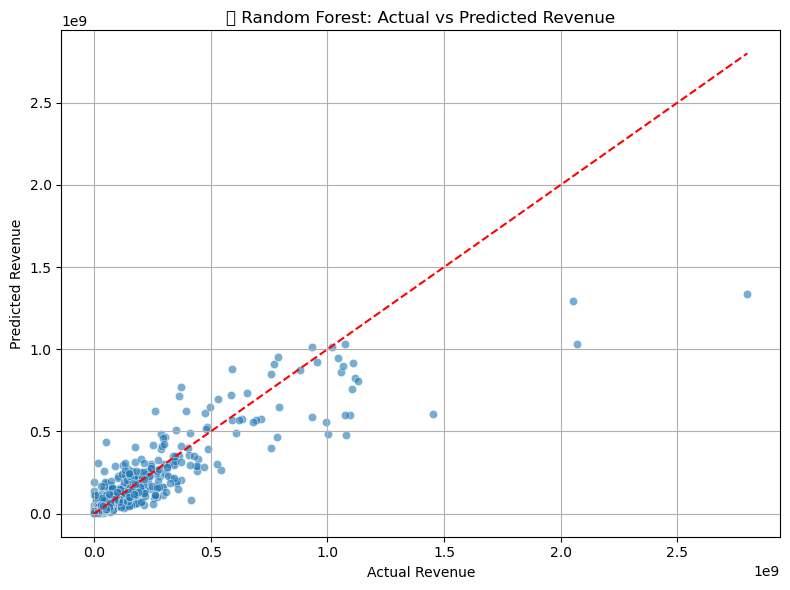

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Plot: Actual vs Predicted Revenue (Random Forest)
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
preds_rf = best_model.predict(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=preds_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('🎬 Random Forest: Actual vs Predicted Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()




/var/folders/vf/hly5stlj5xndydqcwspn6fkm0000gn/T/ipykernel_29241/4270746385.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




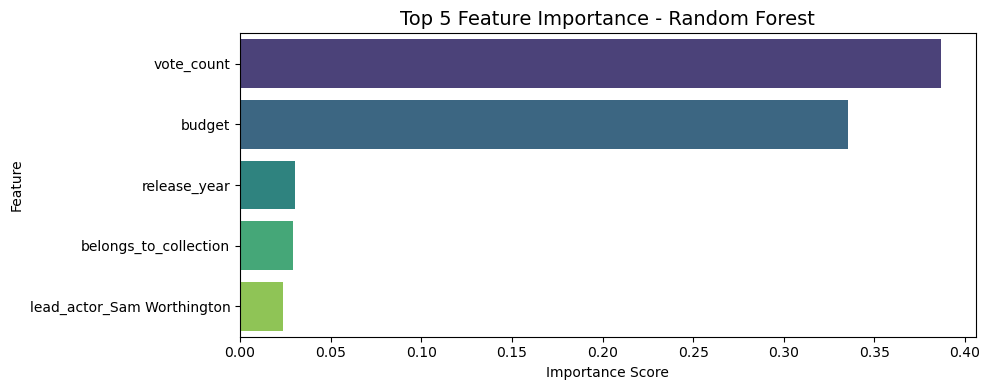

In [ ]:
# 2. Plot: Feature Importance

# Get feature importances from your trained RandomForest model
importances = best_model.feature_importances_
features = X_train.columns

#  Create a Series and sort
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

# Plot the Top 5
top_n = 5
feat_imp = feat_imp.head(top_n)

#  Plot
plt.figure(figsize=(10, 4))  # WIDER and SHORTER for that compact look
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')

# 5. Styling
plt.title(f'Top {top_n} Feature Importance - Random Forest', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [31]:
print(df_model.columns.tolist())

['title', 'release_date', 'budget', 'revenue', 'runtime', 'popularity', 'vote_average', 'vote_count', 'belongs_to_collection', 'profit', 'profit_margin', 'production_company_1492 Pictures', 'production_company_1821 Pictures', 'production_company_1984 Private Defense Contractors', 'production_company_199 Productions', 'production_company_20th Century Fox', 'production_company_20th Century Fox Animation', 'production_company_20th Century Studios', 'production_company_21 Laps Entertainment', 'production_company_2929 Productions', 'production_company_3 Arts Entertainment', 'production_company_3000 Pictures', 'production_company_308 Enterprises', 'production_company_30WEST', 'production_company_3QU Media', 'production_company_40 Acres and a Mule Filmworks', 'production_company_5150 Action', 'production_company_6th & Idaho Motion Picture Company', 'production_company_777 Films Corporation', 'production_company_87Eleven', 'production_company_87North Productions', 'production_company_A Bigger 

In [41]:
genre_columns = [col for col in df_model.columns if col.startswith('genre1_')]

# Use idxmax to find the first genre1_ column with a 1 in it
df_model['genre1'] = df_model[genre_columns].idxmax(axis=1).str.replace('genre1_', '')

In [43]:
import plotly.express as px

#Option 1

fig1 = px.scatter(
    df_model,
    x='budget',
    y='revenue',
    color='genre1',          # color by genre string (e.g., Action, Comedy)
    size='popularity',       # optional: size points by popularity
    hover_data=['title'],    # optional: show movie title on hover
    title='Budget vs Revenue (Colored by Genre)',
    labels={'budget': 'Budget ($)', 'revenue': 'Revenue ($)'}
)

fig1.update_layout(template='plotly_white')
fig1.show()

In [44]:
# 3. Box Plot: Revenue by Genre
fig3 = px.box(df_movies, x='genre1', y='revenue', points="all",
              title='Revenue Distribution by Primary Genre')
fig3.update_layout(xaxis_title='Genre', yaxis_title='Revenue')
fig3.show()